In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#### Euler

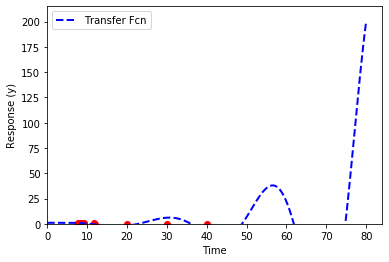

In [22]:
points = pd.DataFrame({'t': [7.62,8.08,8.69,9.22,11.73,11.85,20,30,40], 'd': [1,0.906,0.706,0.52,0.346,0.247,0.153,0.153,0.153]})

plt.figure(1)
plt.plot(t,phi_delayed[0:len(t)],'b--',linewidth=2,label='Transfer Fcn')
plt.scatter(points['t'],points['d'], color='r')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.ylim(0)
plt.xlim(0)
plt.legend(loc='best')
plt.show()

#### Incorporate into greater model

## Baseline Conditions

#### Set Constants and paramaters

In [27]:
#input params
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
M = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/m #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper
K = 5*10e-8

##reset df
df = None

#Input data from paper
df = pd.DataFrame({'Name': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'C', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1'], 
                   'Number': [1, 2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1],
                   'Diameter(µm)': [23.97, 19.17, 15.28, 12.08, 9.46, 7.32, 8, 11.51, 14.53, 17.79, 21.45, 25.70, 30.77],
                   'Length(µm)': [1267.6, 930.3, 543.6, 302.3, 161.2, 154.7, 243.9, 473.9, 272.3, 426.6, 632.5, 844.2, 936.3],
                   'Viscocity(mPAs)': [1.59, 1.50, 1.42, 1.34, 1.28, 1.23, 1.24, 1.33, 1.40, 1.48, 1.55, 1.62, 1.7],
                   'Pressure Drop(mmHg)': [6.93, 5.87, 4.02, 2.70, 1.82, 2.35, 2.62, 1.27, 0.61, 0.89, 1.31, 1.78, 2.01],
                   'Saturation': [0.94, 0.93, 0.92, 0.89, 0.84, 0.765, 0.665, 0.61, 0.5975, 0.5875, 0.5825, 0.5775, 0.5725],
                   'dS': [0.01, 0.01, 0.02, 0.04, 0.0625,0.0875, 0.0775, 0.03375, 0.01125, 0.0075, 0.005, 0.005, 0.005]
                  })


#### Calculate Flows and Vt

In [28]:
#Calculate resistances of each vessel
df['Resistance for U'] = 32 * df['Viscocity(mPAs)'] * df['Length(µm)'].div(df['Diameter(µm)']**2)
df['Resistance for Q'] = 128 * df['Viscocity(mPAs)'] * df['Length(µm)'].div(math.pi*(df['Diameter(µm)']**4))

#Alter resistances for C
#These are aross each pressure drop (explains the doubled resistance for the capillaries as in paralell so have half the flow each (flow is shared))
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U']*2
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q']*2

#Calculate flow and velocity in a single vessel
df['U in single(m/s????)'] = df['Pressure Drop(mmHg)'].div(df['Resistance for U'])
df['Q in single(m^3/s????)'] = df['Pressure Drop(mmHg)'].div(df['Resistance for Q'])

#Find change in saturdation from data on saturation curve
# S = pd.Series([])

#Calculate Vt CHANGE IN SATURATIO  YA SHIT HEAD
df['Vt'] = df['Q in single(m^3/s????)']*cHb*H*df['dS']/M

In [29]:
#all units were in mm so i played around with this equation from the paper
df['X-Area wall(mm^2?)'] = np.pi * ( 0.16*(df['Diameter(µm)'])**2 + 1.4*(df['Diameter(µm)']) + 14 )
df['wall thickness(µm)'] = ( -(df['Diameter(µm)']) + np.sqrt((df['Diameter(µm)'])**2 + (4*(df['X-Area wall(mm^2?)'])/np.pi)) ) / 2

#### Calculate partial pressure in tissue
Equations can be found on the week 1 or 2 notes from class. From steady state version of something on the paper

#### Pull out the baseline conditions

In [30]:
df_base = df
df_base

,Name,Number,Diameter(µm),Length(µm),Viscocity(mPAs),Pressure Drop(mmHg),Saturation,dS,Resistance for U,Resistance for Q,U in single(m/s????),Q in single(m^3/s????),Vt,X-Area wall(mm^2?),wall thickness(µm)
0,A1,1,23.97,1267.6,1.59,6.93,0.9400,0.01000,112.251787,0.248752,0.061736,27.859025,78005.271056,438.213672,4.841407
1,A2,2,19.17,930.3,1.50,5.87,0.9300,0.01000,121.512242,0.421004,0.048308,13.942870,39040.035790,313.016429,4.253658
2,A3,4,15.28,543.6,1.42,4.02,0.9200,0.02000,105.796442,0.576945,0.037997,6.967734,39019.312012,228.546291,3.810683
3,A4,8,12.08,302.3,1.34,2.70,0.8900,0.04000,88.829876,0.775060,0.030395,3.483601,39016.335895,170.463521,3.485850
4,A5,16,9.46,161.2,1.28,1.82,0.8400,0.06250,73.780690,1.049713,0.024668,1.733807,30341.627914,130.572935,3.265971
5,A6,32,7.32,154.7,1.23,2.35,0.7650,0.08750,113.637911,2.700295,0.020680,0.870275,21321.745183,103.110791,3.138293
6,C,64,8.00,243.9,1.24,2.62,0.6650,0.07750,302.436000,6.016773,0.008663,0.435449,9449.251212,111.338044,3.172168
7,V6,32,11.51,473.9,1.33,1.27,0.6100,0.03375,152.243122,1.463178,0.008342,0.867974,8202.351518,161.197683,3.433626
8,V5,16,14.53,272.3,1.40,0.61,0.5975,0.01125,57.782247,0.348476,0.010557,1.750477,5514.003939,214.009514,3.730525
9,V4,8,17.79,426.6,1.48,0.89,0.5875,0.00750,63.838202,0.256826,0.013941,3.465382,7277.302540,281.309064,4.092089


#### dropped by 50%

In [36]:
run_0 = pd.DataFrame({'Name': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'C', 'V6', 'V5', 'V4', 'V3',
       'V2', 'V1']})
run_0['Q'] = np.empty
run_0.loc[0,'Q'] = Q_in
run_0.loc[1,'Q'] = run_0.loc[0,'Q']/2
run_0.loc[2,'Q'] = run_0.loc[1,'Q']/2
run_0.loc[3,'Q'] = run_0.loc[2,'Q']/2
run_0.loc[4,'Q'] = run_0.loc[3,'Q']/2
run_0.loc[5,'Q'] = run_0.loc[4,'Q']/2
run_0.loc[6,'Q'] = run_0.loc[5,'Q']/2
run_0.loc[7,'Q'] = run_0.loc[6,'Q']*2
run_0.loc[8,'Q'] = run_0.loc[7,'Q']*2
run_0.loc[9,'Q'] = run_0.loc[8,'Q']*2
run_0.loc[10,'Q'] = run_0.loc[9,'Q']*2
run_0.loc[11,'Q'] = run_0.loc[10,'Q']*2
run_0.loc[12,'Q'] = run_0.loc[11,'Q']*2

In [38]:
baselines

,Name,Number,Resistance for Q,baseline Q,Vt,wall thickness(µm),Diameter(µm),Length(µm)
0,A1,1,0.248752,27.859025,78005.271056,4.841407,23.97,1267.6
1,A2,2,0.421004,13.942870,39040.035790,4.253658,19.17,930.3
2,A3,4,0.576945,6.967734,39019.312012,3.810683,15.28,543.6
3,A4,8,0.775060,3.483601,39016.335895,3.485850,12.08,302.3
4,A5,16,1.049713,1.733807,30341.627914,3.265971,9.46,161.2
5,A6,32,2.700295,0.870275,21321.745183,3.138293,7.32,154.7
6,C,64,6.016773,0.435449,9449.251212,3.172168,8.00,243.9
7,V6,32,1.463178,0.867974,8202.351518,3.433626,11.51,473.9
8,V5,16,0.348476,1.750477,5514.003939,3.730525,14.53,272.3
9,V4,8,0.256826,3.465382,7277.302540,4.092089,17.79,426.6


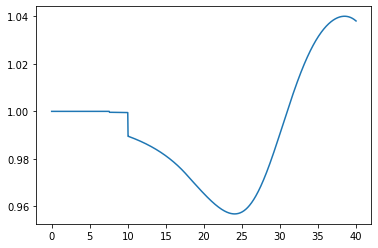

In [181]:
baselines = df_base[['Name','Number','Resistance for Q','Q in single(m^3/s????)','Vt','wall thickness(µm)','Diameter(µm)','Length(µm)']].rename(columns={"Q in single(m^3/s????)": "baseline Q"})

def total_R(baselines,phi):
    C_ = (baselines.loc[6,'Resistance for Q']/2)/phi**4
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

max_time = 40
no = 1001
t = pd.Series(np.linspace(0,max_time,no))

R_tot = pd.Series(np.zeros(len(t)))
Q_tot = pd.Series(np.zeros(len(t)))
Q_norm = pd.Series(np.zeros(len(t)))
pressure_in = pd.Series(np.zeros(len(t)))

ratio_drop = 0.01

for i in range(len(t)):
    if t[i] <= 10:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop

pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out


####Lets incorporate new model
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
delay = 7.62

phi = pd.Series(np.zeros(no))
phi_min = pd.Series(np.zeros(no))
dphidt = pd.array(np.zeros(no))

phi[0] = 1
phi_min[0] = phi_min_baseline
Q_norm[0]=1

dt = max_time/(no-1)
n=1

delay_number = round(delay/dt)

for i in range(len(t)):
    if i >=delay_number: 
        dphidt[i] = (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
        R_tot[i] = total_R(baselines,phi[i])
        Q_tot[i] = pressure_difference[i]/R_tot[i]
        Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
        phi[i+1] = dphidt[i]*dt + phi[i]
        phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
    else:
        phi[i+1]=1
        Q_norm[i+1]=1
        phi_min[i+1] = phi_min_baseline
        
plt.plot(t,Q_norm[0:len(t)])

combined = pd.DataFrame()
combined['t'] = t
combined['phi'] = phi
combined['phi_min'] = phi_min
combined['dphidt'] = dphidt
combined['R_tot'] = R_tot
combined['Q_tot'] = Q_tot
combined['Q_norm'] = Q_norm

In [186]:
combined.iloc[580:630]

,t,phi,phi_min,dphidt,R_tot,Q_tot,Q_norm
580,23.20,0.912897,0.963928,-0.002570,1.268716,26.671226,0.957364
581,23.24,0.912794,0.963887,-0.002459,1.268777,26.669944,0.957318
582,23.28,0.912696,0.963848,-0.002347,1.268835,26.668717,0.957274
583,23.32,0.912602,0.963811,-0.002233,1.268891,26.667545,0.957232
584,23.36,0.912513,0.963775,-0.002118,1.268944,26.666430,0.957192
585,23.40,0.912428,0.963741,-0.002001,1.268994,26.665371,0.957154
586,23.44,0.912348,0.963709,-0.001883,1.269042,26.664371,0.957118
587,23.48,0.912273,0.963679,-0.001764,1.269087,26.663429,0.957084
588,23.52,0.912202,0.963650,-0.001643,1.269129,26.662547,0.957052
589,23.56,0.912136,0.963623,-0.001521,1.269168,26.661725,0.957023


Text(0, 0.5, 'phi')

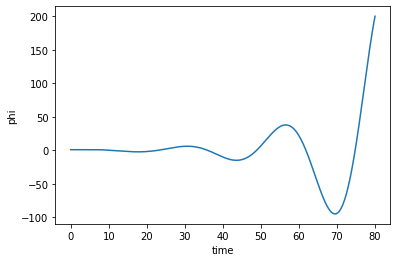

In [71]:


# f = pd.Series(np.zeros(no))
# f[0] = 0.2
# t = np.linspace(0,max_time,no)

# DELAY = round(delay/dt) #not very precise
# phi_delayed = pd.Series(np.ones(DELAY)).append(phi).reset_index().drop('index', axis=1)

for i in range(no-1):
    dphidt[i] = (1/optimised_value_tau)*( -phi_delayed.iloc[i][0] + f[i]*(1-phi_min[i]) + phi_min[i] )
    phi_delayed.iloc[DELAY+i+1][0] = dphidt[i]*dt + phi_delayed.iloc[DELAY+i][0]
    f[i+1] = f[0]*(phi_delayed.iloc[DELAY+i+1][0]**4)
    phi_min[i+1] = 1-(1-phi_min_baseline)*(1-f[i+1])**n

#n=1
#phi_min = 1 - (1 - phi_min_baseline)*(1-f)**n
#initial condition

# plot results
plt.plot(t,phi_delayed[0:len(t)])
plt.xlabel('time')
plt.ylabel('phi')

In [114]:
phi_min[0:1000][dphidt > 0]

764    11.264782
765    11.262813
766    11.262814
767    11.262815
768    11.262816
         ...    
995    11.265681
996    11.265750
997    11.265821
998    11.265894
999    11.265969
Length: 236, dtype: float64

In [116]:
Q_norm[0:1000][dphidt > 0]

764    1.082531
765    1.082531
766    1.082531
767    1.082531
768    1.082531
         ...   
995    1.082507
996    1.082507
997    1.082506
998    1.082506
999    1.082505
Length: 236, dtype: float64

In [117]:
phi_min[760:768]

760       0.000000
761       0.000000
762   -2190.613573
763   -2190.613573
764      11.264782
765      11.262813
766      11.262814
767      11.262815
dtype: float64

In [118]:
Q_norm[760:768]

760    1.000000
761    0.999614
762    0.999614
763    1.082515
764    1.082531
765    1.082531
766    1.082531
767    1.082531
dtype: float64

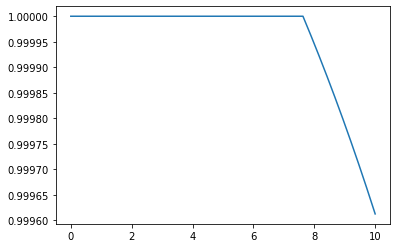

In [152]:
plt.plot(t,phi[0:len(t)])

In [105]:
phi

0           1.000000
1           1.000000
2           1.000000
3           1.000000
4           1.000000
            ...     
996     11007.420531
997     10713.960175
998     10412.716781
999     10103.725364
1000     9787.024540
Length: 1001, dtype: float64

In [99]:
pressure_difference

0      33.8382
1      33.8382
2      33.8382
3      33.8382
4      33.8382
        ...   
995    33.8382
996    33.8382
997    33.8382
998    33.8382
999    33.8382
Length: 1000, dtype: float64

In [144]:
combined.iloc[760:763]

,t,phi,phi_min,dphidt,R_tot,Q_tot,Q_norm
760,7.607608,1.0,0.153000,0.000000e+00,0.000000,0.000000,1.000000
761,7.617618,1.0,0.153000,-1.210485e-17,1.227366,27.848259,0.999614
762,7.627628,1.0,-2190.613573,-9.558138e+02,1.227366,27.848259,0.999614


In [134]:
t[900]

9.00900900900901